A notebook for making a 100-frame movie from 3D dust for Linnea as a test

Two environment variables need to be set in bash: DROPBOX_ROOT, and FFMPEG_ROOT. The DROPBOX_ROOT folder is the path to the top level directory of the dust-holgrams folder shared by Josh. E.g. in bash,

export DROPBOX_ROOT='/Users/catherinezucker/Dropbox/dust-holograms/'

You can also set the path to the FFMPEG executable:

export FFMPEG_PATH='/usr/local/bin'

Ideally, you would set these in your bash_profile profile  (now called zprofile in the latest OS operating systems). Alternatively, if you want to set one of these variables locally in this notebook, you can use:

```
import os
os.environ['DROPBOX_ROOT'] = '/Users/catherinezucker/Dropbox/dust-holograms'
os.environ['FFMPEG_ROOT'] = '/Usr/local/bin'

```

First thing we need to do is figure out how to write some json

In [1]:
import json
import numpy as np
import os
%matplotlib inline
#%matplotlib notebook
from matplotlib import pyplot as plt

This is the camera properties, which we will fix.

In [2]:
t = True
cprops ={
    "projection": "stereographic",
    "step_size": 1,
    "max_dist": 3000.0,
    "fov": 45.0,
    "x_pix": 300,
    "y_pix": 200,
    "vmax": "auto",
    "clip_mode": "tanh",
    "fuzzy": t,
    "randomize_angles": t,
    "euler_convention": "szyz"}

Then we make an empty list of frames to which we can append frames

In [3]:
fprops = []

Linnea asked for 100 frames orbiting around a point with equal distance. We'll assume that the middle of these 100 frames is the Sun, and we'll set some sweep out angle in the Galactic Plane.

In [4]:
nframes = 100 # 100 frames
# orion is at l = 210, distance of 400 pc
x0 = np.cos(210*np.pi/180)*400
y0 = np.sin(210*np.pi/180)*400
orbit_point = np.array([x0, y0, 0]) # I think this means 500 pc toward Galactic center from the Sun...?
angle_sweep = 45 # half of this CCW and half CW from the sun

In [5]:
def sweep(xc, yc, angle_sweep, nframes):
    R = np.sqrt(xc**2+ yc**2)
    phi =np.arctan2(yc, xc)*180/np.pi
    dangs = np.linspace(0, angle_sweep, nframes)
    xs = xc - R*np.cos((phi-angle_sweep/2+dangs)*np.pi/180)
    ys = yc - R*np.sin((phi-angle_sweep/2+dangs)*np.pi/180)
    angs = (dangs-angle_sweep/2+phi)*np.pi/180 ## wait are these in RADIANs??
    return xs, ys, angs

In [6]:
xs, ys, angs = sweep(x0, y0, angle_sweep, nframes)

In [7]:
angs

array([-3.01069296, -2.2252948 ])

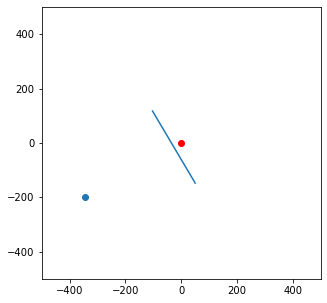

In [8]:
plt.figure(figsize=[5, 5])
plt.scatter(x0, y0)
plt.scatter(0, 0, c='red')
plt.plot(xs, ys)
plt.xlim([-500, 500])
plt.ylim([-500, 500])
plt.savefig('arc')

In [9]:
for i in range(nframes):
    fprops.append({
      "xyz": [xs[i], ys[i], 0.0],
      "angles": [angs[i], 0.0, 0.0]
    })

In [10]:
allprops = {"camera_props": cprops,"frame_props":fprops }

In [11]:
print(json.dumps(allprops,indent=2))

{
  "camera_props": {
    "projection": "stereographic",
    "step_size": 1,
    "max_dist": 3000.0,
    "fov": 45.0,
    "x_pix": 300,
    "y_pix": 200,
    "vmax": "auto",
    "clip_mode": "tanh",
    "fuzzy": true,
    "randomize_angles": true,
    "euler_convention": "szyz"
  },
  "frame_props": [
    {
      "xyz": [
        50.167783035748755,
        -147.78952311197943,
        0.0
      ],
      "angles": [
        -3.0106929596902186,
        0.0,
        0.0
      ]
    },
    {
      "xyz": [
        -102.90558991028715,
        117.34133611649406,
        0.0
      ],
      "angles": [
        -2.2252947962927703,
        0.0,
        0.0
      ]
    }
  ]
}


I am setting a variable called run_name which is the name of the subfolder that will write out the current run.

In [12]:
run_name = 'orion_run'

if os.path.isdir("{}/{}/".format(os.environ['DROPBOX_ROOT'],run_name)) == False:
    os.mkdir("{}/{}/".format(os.environ['DROPBOX_ROOT'],run_name))

In [13]:
with open('{}/{}/test_100.json'.format(os.environ['DROPBOX_ROOT'],run_name), 'w') as outfile:
    json.dump(allprops, outfile,indent=2)

In [14]:
os.system("python3 project_frames.py {}/{}/test_100.json {}/leike2020_bayestar19_splice.npy {}/{}/test100_{{:05d}}.png"
          .format(os.environ['DROPBOX_ROOT'],run_name,os.environ['DROPBOX_ROOT'],os.environ['DROPBOX_ROOT'],run_name))
          

os.system("{}/ffmpeg -r 30 -start_number 0 -i {}/{}/test100_%05d.png -c:v libx264 -s 600x400 -r 30 -pix_fmt yuv420p {}/{}/test100_5.mp4"
          .format(os.environ['FFMPEG_ROOT'],os.environ['DROPBOX_ROOT'],run_name,os.environ['DROPBOX_ROOT'],run_name))



Loaded specifications for 2 images.


100% (2 of 2) |##########################| Elapsed Time: 0:01:31 ETA:  00:00:00

All workers done.
0.397824734759316
Loading map ...
Ray-casting frames ...
frame 0: vmax = 0.08959424003570712
frame 1: vmax = 0.07928592212105287
Worker finished.


ffmpeg version 4.4.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with Apple clang version 13.0.0 (clang-1300.0.29.3)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.4.1_5 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libbluray --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libsoxr --enable-libzmq --enable-libzimg --disable-libjack --disable-indev=jack --enable-avresample --

0

ct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
Output #0, mp4, to '/Users/catherinezucker/Dropbox/dust-holograms/orion_run/test100_5.mp4':
  Metadata:
    encoder         : Lavf58.76.100
  Stream #0:0: Video: h264 (avc1 / 0x31637661), yuv420p(tv, progressive), 600x400, q=2-31, 30 fps, 15360 tbn
    Metadata:
      encoder         : Lavc58.134.100 libx264
    Side data:
      cpb: bitrate max/min/avg: 0/0/0 buffer size: 0 vbv_delay: N/A
frame=    2 fps=0.0 q=-1.0 Lsize=       8kB time=00:00:00.03 bitrate=1920.4kbits/s speed= 1.6x    
video:7kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 11.891137%
[libx264 @ 0x7f8fad008e00] frame I:1     Avg QP:23.65  size:  3238
[libx264 @ 0x7f8fad008e00] frame P:1     Avg QP:23.40  size:  3237
[libx264 @ 0x7f8fad008e00] mb I  I16..4: 41.7% 58.2%  0.1%
[libx264 @ 0x7f8fad008e00]

In [ ]:
#python3 project_frames.py test100.json /Users/jegpeek/leike2020_bayestar19_splice.npy "test100_{:05d}.png"
#/Users/jegpeek/ffmpeg -r 30 -start_number 0 -i pattern_%05d.png -c:v libx264 -s 600x400 -r 30 -pix_fmt yuv420p test3.mp4

#/Users/jegpeek/ffmpeg -r 30 -start_number 0 -i test100_%05d.png -c:v libx264 -s 600x400 -r 30 -pix_fmt yuv420p test100.mp4